In [1]:
import argparse
import torch
from torch import nn
from torchvision import datasets
from torchvision.transforms import transforms, InterpolationMode

device = 'cuda' if torch.cuda.is_available() else 'cpu'

def custom_config(args):
    args.img_size = 180
    args.dim_first = 2
    args.dim_second = 3
    args.dim_third = 4
    args.batch_size = 100
    args.margin_loss = 1.0
    args.border  = 21
    args.nms_size = 10 # normal é 10, alterei so pra avaliar o match
    args.box_size = 41
    args.exported = False
    return args



parser = argparse.ArgumentParser()
args = parser.parse_args([])

args =custom_config(args)

In [2]:
from e2cnn import gspaces
from e2cnn import nn as enn    #the equivariant layer we need to build the model
from torch import nn
class Feature(nn.Module):
    def __init__(self,n_channel=2) -> None:
        super().__init__()
        r2_act = gspaces.Rot2dOnR2(N=36)      

        feat_type_in  = enn.FieldType(r2_act,  n_channel*[r2_act.trivial_repr])
        feat_type_out = enn.FieldType(r2_act, 5*[r2_act.regular_repr])     
        self.input_type = feat_type_in

        self.block1 = enn.SequentialModule(                
                enn.R2Conv(feat_type_in, feat_type_out, kernel_size=5, padding=1, bias=False),
                enn.InnerBatchNorm(feat_type_out),
                enn.ReLU(feat_type_out, inplace=True)
                )
        
        self.pool1 = enn.PointwiseAvgPoolAntialiased(feat_type_out, sigma=0.66, stride=1, padding=0)

        feat_type_in  = self.block1.out_type
        feat_type_out = enn.FieldType(r2_act, 1*[r2_act.regular_repr])
        self.block2 = enn.SequentialModule(                
                enn.R2Conv(feat_type_in, feat_type_out, kernel_size=5, padding=2, bias=False),
                enn.InnerBatchNorm(feat_type_out),
                enn.ReLU(feat_type_out, inplace=True),
                )
        # self.pool2 = enn.PointwiseAvgPool(feat_type_out, 21)
        self.gpool = enn.GroupPooling(feat_type_out)
        
                
    def forward(self,X1)->torch.Tensor:
        x = enn.GeometricTensor(X1, self.input_type)
        n_dim = X1.shape[-1]
        mask = enn.MaskModule(self.input_type, n_dim, margin=2).to(device)
        x = mask(x)
        x = self.block1(x)
        x = self.pool1(x)
        x = self.block2(x)
        # x = self.pool2(x)
        x = self.gpool(x)   
        return x.tensor
    

class Discriminator(nn.Module):
    def __init__(self, n_classes=10) -> None:
        super().__init__()
        #criar camadas densa a partir de x que é uma cnn
        # self.dense1 = nn.Linear(2*1*625, 512)
        self.dense1 = nn.Linear(2*1*1225, 512)
        self.dense2 = nn.Linear(512, 128)
        self.droupout = nn.Dropout(0.2)
        self.activation = nn.LeakyReLU()
        #self.activation = nn.ELU()
        #função de ativação ideal para retornar um valor entre 0 e 1
        self.activation2 = nn.Tanh()

    
    def forward(self,X1,X2)->torch.Tensor:
        flatten_x1 = X1.view(X1.size(0), -1)
        flatten_x2 = X2.view(X2.size(0), -1)
        x = torch.cat((flatten_x1,flatten_x2),dim=1)
        # x = self.dense1(x)
        # x = self.dense2(x)
               
        x = self.droupout(self.dense1(x))
        x = self.activation(x)
        x = self.droupout(self.dense2(x))
        x = self.activation(x)
        
        # Calculando a distância euclidiana
        distance = torch.norm(x, dim=1)
        x = self.activation(distance)
        return x

    
class Siamesa(nn.Module):
    def __init__(self,n_channel=2) -> None:
            super().__init__()
            self.feature = Feature(n_channel=n_channel)
            self.discriminator = Discriminator()
    
    def forward(self,X1,X2)->torch.Tensor:
        x1 = self.feature(X1)
        x2 = self.feature(X2)
        x = self.discriminator(x1,x2)
        return x
    
    
def load_model(model, filepath):
    model.load_state_dict(torch.load(filepath))
    model.eval()
    print(f"Model loaded from {filepath}")
    

path_siamese = '.\data\models\siamese_model.pth'
model = Siamesa(n_channel=1).to(device)
# load_model(model,'.\data\models\siamese_model_best.pth')


c:\Users\renga\PycharmProjects\singular_points\venv\lib\site-packages\e2cnn\nn\modules\r2_conv\basisexpansion_singleblock.py:80: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ..\aten\src\ATen/native/IndexingUtils.h:28.)
  full_mask[mask] = norms.to(torch.uint8)


In [3]:
transform = transforms.Compose([
    transforms.Resize((41, 41), interpolation=InterpolationMode.NEAREST),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


# Carregar conjunto de dados MNIST para treinamento e teste
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Definir tamanho dos lotes (batches)
batch_size = 8

# Criar objetos DataLoader para treinamento e teste
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

MODEL_PATH = "./data/models/model_flowers_ssim.pt"

single_point_model = load_model_trained(args,device,path=MODEL_PATH)
iterator=iter(testloader)
batch = next(iterator)
img_batch, labels =batch
print(len(img_batch),labels) #4

In [4]:
from tqdm import tqdm
from torch.optim.lr_scheduler import ExponentialLR

#Create methods to train the model
def train_one_epoch(model,train_loader,optimizer,loss_fn,device='cpu'):
    model.train()
    total_loss = 0.

    for data,labels in tqdm(train_loader, desc="Train "):
        data = data.to(device)
        optimizer.zero_grad()            

        #refactor block
        data_pos = random_transform(data)
        output_pos = model(data,data_pos)
        #sift rool data
        data_neg =torch.roll(data_pos, 1, 0)
        output_neg = model(data,data_neg)

        #calculate loss
        loss = loss_fn(output_pos,output_neg)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss/len(train_loader.dataset)

#Create methods to test the model
def test(model,test_loader,loss_fn,device='cpu'):
    model.eval()
    test_loss = 0.
    correct = 0.
    with torch.no_grad():
        for data in tqdm(test_loader, desc="Tests "):
            data = data.to(device)
            
            #refactor block
            data_pos = random_transform(data)
            output_pos = model(data,data_pos)
            #sift rool data
            data_neg =torch.roll(data_pos, 1, 0)
            output_neg = model(data,data_neg)

            test_loss +=  loss_fn(output_pos,output_neg).item()
    return test_loss/len(test_loader.dataset)
    

#Create methods to calculate loss
def loss_fn(output_pos,output_neg):    
    margim = args.margin_loss
    zero = torch.tensor(0.,requires_grad=True).to(output_pos.device)
    loss = output_pos - output_neg + margim
    loss = torch.max(torch.tensor(0),loss)
    loss = torch.sum(loss)  # Reduzir para um escalar
    return loss

#Create methods random_transform with kornia with import
import kornia
def random_transform(x):
    x = kornia.augmentation.RandomAffine(degrees=90, translate=(0.1, 0.1), scale=(0.95, 1.05), shear=10)(x)
    return x



def train(model, train_loader, test_loader, loss_fn, epochs=10, device='cpu'):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
    scheduler = ExponentialLR(optimizer, gamma=0.75)

    best_loss = float('inf')
    best_model = None
    epochs_without_improvement = 0

    for epoch in range(epochs):
        loss_train = train_one_epoch(model, train_loader, optimizer, loss_fn, device)
        loss_test = test(model, test_loader, loss_fn, device)

        print(f'Epoch: {epoch}, Train Loss: {loss_train:.4f}, Test Loss: {loss_test:.4f}')

        # Verificar se a perda melhorou
        if loss_test < best_loss:
            best_loss = loss_test
            epochs_without_improvement = 0
            # Salvar o estado do modelo
            best_model = model.state_dict()
        else:
            epochs_without_improvement += 1

        # Verificar a condição de parada
        if epochs_without_improvement == 50:
            print(f"No improvement in loss for {epochs_without_improvement} epochs. Training stopped.")
            break

        # Atualizar a taxa de aprendizado
        if (epoch % 10 == 0) and (epoch != 0):
            scheduler.step()

        print('initial_lr:', optimizer.param_groups[0]['initial_lr'], 'lr:', optimizer.param_groups[0]['lr'],' epochs_without_improvement ',epochs_without_improvement)

    # Carregar a melhor configuração do modelo
    model.load_state_dict(best_model)
    print(f'Epoch: {epoch}, Best Loss: {best_loss:.4f}')
    

train(model,train_loader,test_loader,loss_fn,epochs=3,device=device)

Train :  10%|▉         | 735/7500 [01:38<15:09,  7.44it/s] 


KeyboardInterrupt: 

: 

In [ ]:
import kornia
import numpy as np
def random_transform(x):
    x = kornia.augmentation.RandomAffine(degrees=90, translate=(0.1, 0.1), scale=(0.95, 1.05), shear=10)(x)
    return x


def copy_tensor(tensor,times):
    tensor = tensor.repeat(times,1,1,1)
    return tensor

def matching_single_points(data1, data2, apply_random_transform=False):
    size = len(data1)
    matches = []
    model.eval()
    with torch.no_grad():
        for i in range(len(data2)):
            img_temp = data2[i][None]

            if apply_random_transform:
                img_temp2 = random_transform(img_temp)
            else:
                img_temp2 = img_temp.clone()

            data_temp = copy_tensor(img_temp2, size)
            if apply_random_transform:
                data_temp = random_transform(data_temp)
            distances = model(data1, data_temp)
            print(i, distances)
            match_index = distances.argmin().item()
            matches.append((i, match_index))
    print(matches)
    return np.array(matches)

#plot 2 bath de 8 imagens(MNIST) um em cima do outro
import matplotlib.pyplot as plt
import numpy as np

def plot_batchs(batch1, batch2):
    fig, axes = plt.subplots(2, batch1.shape[0], figsize=(10, 4))
    fig.tight_layout()

    for i, ax in enumerate(axes[0]):
        image1 = np.squeeze(batch1[i].numpy(), axis=0)
        ax.imshow(image1, cmap='gray')
        ax.axis('off')

    for i, ax in enumerate(axes[1]):
        image2 = np.squeeze(batch2[i].numpy(), axis=0)
        ax.imshow(image2, cmap='gray')
        ax.axis('off')

    plt.show()

tensor([7, 0, 6, 5, 6, 8, 3, 2])


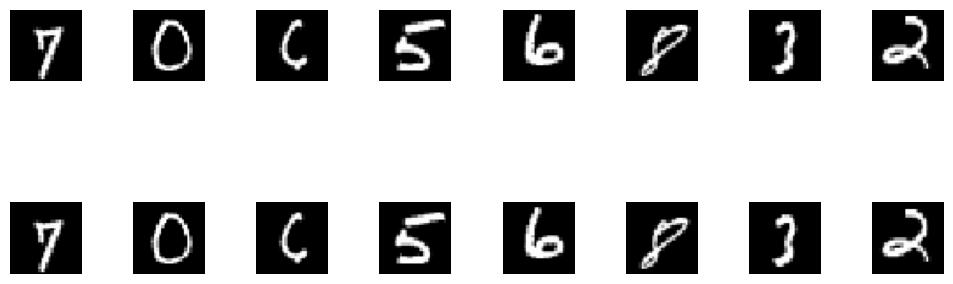

0 tensor([0.4142, 0.4690, 0.3974, 0.4545, 0.4556, 0.4157, 0.4341, 0.3997],
       device='cuda:0')
1 tensor([0.4362, 0.5160, 0.4983, 0.5171, 0.5138, 0.4484, 0.4604, 0.5040],
       device='cuda:0')
2 tensor([0.4240, 0.4231, 0.3880, 0.4578, 0.4123, 0.4310, 0.4185, 0.4667],
       device='cuda:0')
3 tensor([0.4183, 0.4558, 0.4077, 0.4777, 0.4609, 0.4306, 0.4465, 0.4317],
       device='cuda:0')
4 tensor([0.4346, 0.5036, 0.4725, 0.5026, 0.4915, 0.4433, 0.4569, 0.5154],
       device='cuda:0')
5 tensor([0.4229, 0.4969, 0.4168, 0.4802, 0.4594, 0.4131, 0.4811, 0.4203],
       device='cuda:0')
6 tensor([0.3837, 0.4472, 0.3897, 0.4568, 0.4644, 0.3653, 0.3912, 0.3917],
       device='cuda:0')
7 tensor([0.4509, 0.5095, 0.4517, 0.5117, 0.5138, 0.4283, 0.4856, 0.5059],
       device='cuda:0')
[(0, 2), (1, 0), (2, 2), (3, 2), (4, 0), (5, 5), (6, 5), (7, 5)]


In [ ]:
# Iterar sobre os lotes de treinamento
model.eval()
for images, labels in train_loader:
    images = images.to(device)
    print(labels)
    plot_batchs(images.cpu(),images.cpu())
    matching_single_points(images, images, apply_random_transform=False)
    break